In [1]:
import numpy as np
import pandas as pd
import loss_constraint as lc
import algorithm as al 
import matplotlib.pyplot as plt 
import os
from os import walk

In [2]:
data = pd.read_csv(r'D:\sun_python\PROJECT\生产调度\100组数据集\数据集\data_103.csv')
data = data.drop(columns= ['Unnamed: 0'],axis = 1)
data['车顶颜色'][data['车顶颜色'] == '无对比颜色'] = data['车身颜色'][data['车顶颜色'] == '无对比颜色']
data 

车型   车身颜色 车顶颜色            物料编号 发动机 变速器
0    A    天空灰   石黑  BZ14GCY0000292  燃油  四驱
1    B  水晶珍珠白   石黑  AZ32GCY0000260  燃油  两驱
2    A    闪耀黑  闪耀黑  AZ62GFF0000250  混动  两驱
3    B    天空灰  天空灰  AZ62GCY0000300  燃油  两驱
4    B    飞行蓝   石黑  AZ62GFF0000252  混动  两驱
..  ..    ...  ...             ...  ..  ..
98   A  水晶珍珠白   石黑  AZ64GCY0000289  燃油  四驱
99   B    飞行蓝   石黑  AZ62GCY0000243  燃油  两驱
100  A    天空灰   石黑  AZ62GFF0000275  混动  两驱
101  A    天空灰   石黑  BZ14GCY0000292  燃油  四驱
102  B    飞行蓝   石黑  AZ62GCY0000243  燃油  两驱

[103 rows x 6 columns]

In [ ]:
population, mean_cost, best_cost, mean_record, best_record = al.GA(data,200,5000,0.2,0.3)

Text(0, 0.5, 'loss')

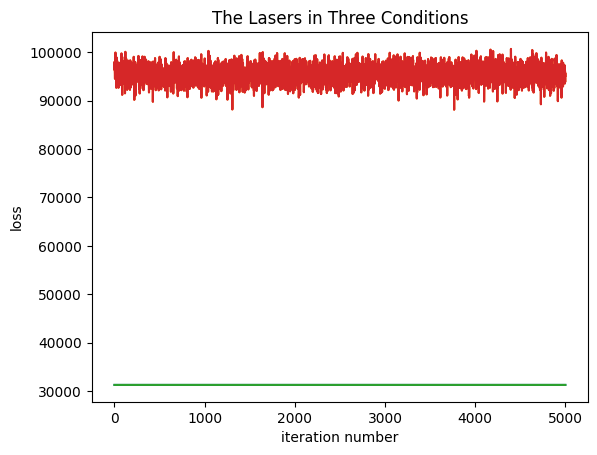

In [9]:
import matplotlib.pyplot as plt 
y1 = best_record
y2 = mean_record
x = [ i for i in range(1,5001)]

l1=plt.plot(x,y1,label='type1')
l2=plt.plot(x,y2,label='type2')

plt.plot(x,y1,x,y2)
plt.title('The Lasers in Three Conditions')
plt.xlabel('iteration number')
plt.ylabel('loss')

#### 统计各个生产计划中四驱两驱的比例

In [2]:
# 设置路径
path = r'D:\sun_python\PROJECT\生产调度\100组数据集\数据集'
os.chdir(path)

# 遍历文件
res = []
for (dir_path, dir_name, file_name) in walk(path,topdown=True):
    res.extend(file_name)


length = np.array([eval(i.split('_')[1].split('.')[0]) for i in res])
id_sort = np.argsort(length)
res_new = []
for i in id_sort:
    res_new.append(res[i])

length = length[id_sort]


# 拼接全路径
final_path = []
for file_name in res_new:
    tmp_final_path = os.path.join(path, file_name)
    final_path.append(tmp_final_path)
'''
ratio = []
for i in range(0,len(final_path)):
    cur_path = final_path[i]
    data = pd.read_csv(cur_path)
    ratio.append(data['变速器'][data['变速器'] == '四驱'].shape[0]/data['变速器'][data['变速器'] == '两驱'].shape[0])

max(ratio) # 四驱/两驱的比例最大为0.33，容易生成满足要求的序列
len(ratio)
'''

"\nratio = []\nfor i in range(0,len(final_path)):\n    cur_path = final_path[i]\n    data = pd.read_csv(cur_path)\n    ratio.append(data['变速器'][data['变速器'] == '四驱'].shape[0]/data['变速器'][data['变速器'] == '两驱'].shape[0])\n\nmax(ratio) # 四驱/两驱的比例最大为0.33，容易生成满足要求的序列\nlen(ratio)\n"

In [ ]:
writer = pd.ExcelWriter(r'D:\sun_python\PROJECT\生产调度\figure\case_1\output.xlsx')
all_best_record = []
all_mean_record = []
for case_id in range(0,100):
#------------------------------------------------------------
#依次处理生产计划
    path = final_path[case_id]
    data = pd.read_csv(path)
    data = data.drop(columns= ['Unnamed: 0'],axis = 1)
    data['车顶颜色'][data['车顶颜色'] == '无对比颜色'] = data['车身颜色'][data['车顶颜色'] == '无对比颜色']
    #设置群体数目和迭代次数
    N = min(400 + 100*int(length[case_id]/100),1000)
    T = min(600 + 200*int(length[case_id]/100),3000)
    print(res_new[case_id].split('.')[0] + '  群体数量' + str(N) + '   迭代次数' + str(T))
    population, mean_cost, best_cost, mean_record, best_record = al.GA(data,N,T,0.2,0.3)
    
    all_best_record.append(best_record)
    all_mean_record.append(mean_record)

#--------------------------------
#可视化目标函数变化并保存
    y1 = best_record
    y2 = mean_record
    x = [ i for i in range(1,T+1)]

    l1=plt.plot(x,y1,label='type1')
    l2=plt.plot(x,y2,label='type2')

    plt.plot(x,y1,x,y2)
    plt.title('The Lasers in Three Conditions')
    plt.xlabel('iteration number')
    plt.ylabel('loss')
    tmp_path = os.path.join(r'D:\sun_python\PROJECT\生产调度\figure\case_1',res_new[case_id].split('.')[0])
    plt.savefig(tmp_path)
    plt.clf()
#------------------------------
#将结果保存至指定的excel中
    #保留总用时最少的50个样本
    cost = []
    for i in range(0,N):
        plan = population[i]
        cost.append(lc.loss(plan, data)[3])
    
    # 保留前50个最佳样本的id
    sel_id = np.argpartition(np.array(cost), 50)[0:50]
    #best_population = population[sel_id]
    best_population = [population[id] for id in sel_id]



    col = []
    for j in range(0,length[case_id]):
        col.append('Variable ' + str(j))
    df = pd.DataFrame(best_population,columns= col)
    df.to_excel(writer,res_new[case_id].split('.')[0],index=False)
    writer.save()

  

In [ ]:
writer = pd.ExcelWriter(r'D:\sun_python\PROJECT\生产调度\figure\case_1\output_res.xlsx')
res_length = length[44:]
all_best_record = []
all_mean_record = []
#for case_id in range(0,100):
for case_id in range(44,44+res_length.shape[0]):
#------------------------------------------------------------
#依次处理生产计划
    path = final_path[case_id]
    data = pd.read_csv(path)
    data = data.drop(columns= ['Unnamed: 0'],axis = 1)
    data['车顶颜色'][data['车顶颜色'] == '无对比颜色'] = data['车身颜色'][data['车顶颜色'] == '无对比颜色']
    #设置群体数目和迭代次数
    #N = min(400 + 100*int(length[case_id]/100),1000)
    #T = min(600 + 200*int(length[case_id]/100),3000)
    N = 200
    T = 3000
    print(res_new[case_id].split('.')[0] + '  群体数量' + str(N) + '   迭代次数' + str(T))
    population, mean_cost, best_cost, mean_record, best_record = al.GA(data,N,T,0.2,0.3)
    
    all_best_record.append(best_record)
    all_mean_record.append(mean_record)

#--------------------------------
#可视化目标函数变化并保存
    y1 = best_record
    y2 = mean_record
    x = [ i for i in range(1,T+1)]

    l1=plt.plot(x,y1,label='type1')
    l2=plt.plot(x,y2,label='type2')

    plt.plot(x,y1,x,y2)
    plt.title('The Lasers in Three Conditions')
    plt.xlabel('iteration number')
    plt.ylabel('loss')
    tmp_path = os.path.join(r'D:\sun_python\PROJECT\生产调度\figure\case_1',res_new[case_id].split('.')[0])
    plt.savefig(tmp_path)
    plt.clf()
#------------------------------
#将结果保存至指定的excel中
    #保留总用时最少的50个样本
    cost = []
    for i in range(0,N):
        plan = population[i]
        cost.append(lc.loss(plan, data)[3])
    
    # 保留前50个最佳样本的id
    sel_id = np.argpartition(np.array(cost), 50)[0:50]
    best_population = [population[id] for id in sel_id]



    col = []
    for j in range(0,length[case_id]):
        col.append('Variable ' + str(j))
    df = pd.DataFrame(best_population,columns= col)
    df.to_excel(writer,res_new[case_id].split('.')[0],index=False)
    writer.save()

In [ ]:
#sheet[list(sheet.keys())[0]]
#将第一次的两个excel结果写到一起
'''
sheet=pd.read_excel(r"D:\sun_python\PROJECT\生产调度\figure\case_1\output.xlsx",sheet_name=None)
print(list(sheet.keys()))
sheet_res=pd.read_excel(r"D:\sun_python\PROJECT\生产调度\figure\case_1\output_res.xlsx",sheet_name=None)
print(list(sheet_res.keys()))


writer = pd.ExcelWriter(r'D:\sun_python\PROJECT\生产调度\figure\case_1\case_1_result.xlsx')
for i in range(0,44):
    df = sheet[list(sheet.keys())[i]]
    col = []
    for j in range(1,df.shape[1]+1):
        col.append('Variable ' + str(j))
    df.columns = col
    df.to_excel(writer,list(sheet.keys())[i],index=False)
    writer.save()

for j in range(44,100):
    df = sheet_res[list(sheet_res.keys())[i-44]]
    col = []
    for j in range(1,df.shape[1]+1):
        col.append('Variable ' + str(j))
    df.columns = col
    df.to_excel(writer,list(sheet_res.keys())[i],index=False)
    writer.save()
'''